# Segmentación Semántica con SegNet, U-Net y DeepLabv3+

**Autora:** Julia García Vega

**Fecha:** 02/07/2024

**Descripción:** Implementación y comparación de las arquitecturas SegNet, U-Net y DeepLabv3+ para la segmentación semántica de múltiples clases.


## Configuración inicial

In [1]:
# para cargar los datos
import os
!pip install roboflow
from roboflow import Roboflow

# para leer y procesar imágenes
import imageio
from PIL import Image

# para trabajar con arrays
import numpy as np

# para visualizaciones de imágenes y gráficos
import matplotlib.pyplot as plt

# para la generación de números aleatorios
import random

# para construir y ejecutar modelos de aprendizaje profundo
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50

# para descargar el fichero del modelo resultante
from google.colab import files

# para métricas de evaluación de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, jaccard_score, f1_score, accuracy_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.2 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler

In [2]:
CLASSES_NAMES = ['fondo', 'acera', 'baldosas podotáctiles', 'banco', 'carretera', 'pared', 'paso de cebra', 'vegetación']
BACKGROUND = [255,255,255]
SIDEWALK = [155, 155, 155]
PODOTACTILE_PAVEMENT = [255, 89, 94]
BENCH = [255, 146, 76]
ROAD = [28, 48, 74]
WALL = [255, 202, 58]
CROSSWALK = [25, 130, 196]
VEGETATION = [138, 201, 38]
COLOR_DICT = np.array([BACKGROUND, SIDEWALK, PODOTACTILE_PAVEMENT, BENCH, ROAD, WALL, CROSSWALK, VEGETATION])
TARGET_SHAPE_IMG = [128, 128, 3]
TARGET_SHAPE_MASK = [128, 128, 1]
BATCH_SIZE = 32
NUM_CLASSES = 8
TRAIN_DIR = '/content/Elementos-acera-2-12/train/'
VALID_DIR = '/content/Elementos-acera-2-12/valid/'
TEST_DIR = '/content/Elementos-acera-2-12/test/'

In [3]:
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
    colormap = COLOR_DICT
    if np.max(label) > len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

## Importación de los datos

Se procede a descargar el conjunto de datos del proyecto personal de Roboflow en el que se ha llevado acabo la anotación de las imágenes. Está compuesto por 5217 y se distinguen las siguientes clases:

*   Fondo
*   Acera
*   Baldosas podotáctiles
*   Banco
*   Carretera
*   Pared
*   Paso de cebra
*   Vegetación

In [4]:
# IMPORTANTE: La siguiente línea contiene la API key de Roboflow, la cual ha sido reemplazada por asteriscos por motivos de seguridad.
# En caso de necesitar acceso a la API key original para la reproducción o evaluación del trabajo, por favor, solicitarla a juliagarve@usal.es.

rf = Roboflow(api_key="********************")
project = rf.workspace("tfg-nrlv7").project("elementos-acera-2")
dataset = project.version(12).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Elementos-acera-2-12 in png-mask-semantic:: 100%|██████████| 11926/11926 [00:01<00:00, 6151.10it/s]


In [5]:
def LoadData (path):
    """
    Carga los datos devolviendo dos listas, una con los nombres de los ficheros
    de imágenes y otra con los nombres de los ficheros de las máscaras
    """
    #Obtener un listado de los archivos en esa ubicación
    dataset = os.listdir(path)

    #Filtrar respectivamente las imágenes (archivos .jpg) y las máscaras (archivos .png)
    image_dataset = [file_name for file_name in dataset if file_name.endswith('.jpg')]
    mask_dataset = [file_name for file_name in dataset if file_name.endswith('.png')]

    # Ordenar ambas listas para que tengan en el mismo índice la imagen y máscara correspondiente
    image_dataset.sort()
    mask_dataset.sort()

    return image_dataset, mask_dataset

train_image_dataset, train_mask_dataset = LoadData(TRAIN_DIR)
valid_image_dataset, valid_mask_dataset = LoadData(VALID_DIR)
test_image_dataset, test_mask_dataset = LoadData(TEST_DIR)

In [6]:
NUM_TRAIN_IMAGES = len(train_mask_dataset)
NUM_VALID_IMAGES = len(valid_mask_dataset)
NUM_TEST_IMAGES = len(test_mask_dataset)

print("Número imágenes entrenamiento: ", NUM_TRAIN_IMAGES)
print("Número imágenes validación: ", NUM_VALID_IMAGES)
print("Número imágenes test: ", NUM_TEST_IMAGES)

Número imágenes entrenamiento:  5217
Número imágenes validación:  495
Número imágenes test:  247


Inicialmente, debido a que se consideraron dos clases adicionales (escaleras de subida y escaleras de bajada), al eliminarlas y extraer el conjunto de datos de Roboflow los valores enteros correspondientes con cada clase quedaron descuadrados siendo asignadas por Roboflow de la siguiente manera [0, 1, 2, 3, 4, 7, 8, 9] como se puede observar a continuación. Por ello, se procede a corregir este hueco en la secuencia sustituyendo la clase 7 por la clase 5, la clase 8 por la clase 6 y la clase 9 por la clase 7.

In [7]:
def testUniqueValues(path, mask_dataset):
    """
    Comprueba los valores únicos existentes en las máscaras
    """
    # Lista para almacenar todos los valores únicos de píxeles
    unique_total_values = set()
    i=0
    # Recorrer todos los píxeles de la imagen
    for mask_name in mask_dataset:
        # Cargar la imagen
        image_path = os.path.join(path, mask_name)
        image = imageio.imread(image_path)
        # Obtener los valores únicos de la imagen actual
        unique_image_values = np.unique(image)
        # Agregar los valores únicos de la imagen actual al conjunto total
        unique_total_values.update(unique_image_values)

    # Convertir el conjunto de valores únicos en una lista para imprimir
    unique_total_values = list(unique_total_values)

    # Imprimir los valores únicos de todos los píxeles en todas las imágenes
    print("Valores únicos de píxeles en todo el conjunto de imágenes:")
    print(unique_total_values)

In [8]:
def adjustUniqueValues(path, mask_dataset):
    """
    Ajusta los valores únicos existentes en las máscaras para corregir la falta de clases
    """
    # Lista para almacenar todos los valores únicos de píxeles
    unique_total_values = set()
    i=0
    # Recorrer todos los píxeles de la imagen
    for mask_name in mask_dataset:
        # Cargar la imagen
        image_path = os.path.join(path, mask_name)
        image = imageio.imread(image_path)
        # Reemplazar los valores 7, 8 y 9 por 5, 6 y 7 respectivamente
        image = np.where(image == 7, 5, image)
        image = np.where(image == 8, 6, image)
        image = np.where(image == 9, 7, image)
        # Obtener los valores únicos de la imagen actual
        unique_image_values = np.unique(image)
        # Agregar los valores únicos de la imagen actual al conjunto total
        unique_total_values.update(unique_image_values)

        # Guardar la imagen modificada en la misma ubicación con el mismo nombre
        imageio.imwrite(image_path, image)

    # Convertir el conjunto de valores únicos en una lista para imprimir
    unique_total_values = list(unique_total_values)

    # Imprimir los valores únicos de todos los píxeles en todas las imágenes
    print("Valores únicos de píxeles en todo el conjunto de imágenes:")
    print(unique_total_values)

In [9]:
testUniqueValues(TRAIN_DIR, train_mask_dataset)
testUniqueValues(VALID_DIR, valid_mask_dataset)
testUniqueValues(TEST_DIR, test_mask_dataset)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 7, 8, 9]


In [10]:
adjustUniqueValues(TRAIN_DIR, train_mask_dataset)
adjustUniqueValues(VALID_DIR, valid_mask_dataset)
adjustUniqueValues(TEST_DIR, test_mask_dataset)

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]
Valores únicos de píxeles en todo el conjunto de imágenes:
[0, 1, 2, 3, 4, 5, 6, 7]


## Visualización de imágenes y su máscara correspondiente

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Dimensión imágen:  (640, 640, 3)
Dimensión máscara:  (640, 640)
Dimensión imágen:  (640, 640, 3)
Dimensión máscara:  (640, 640)


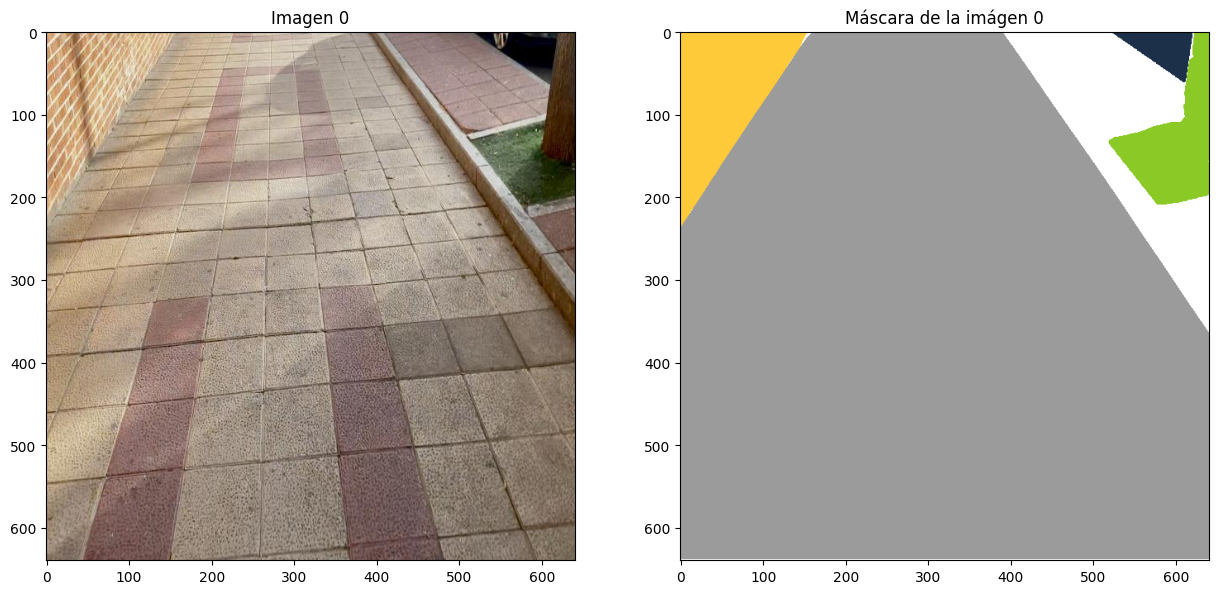

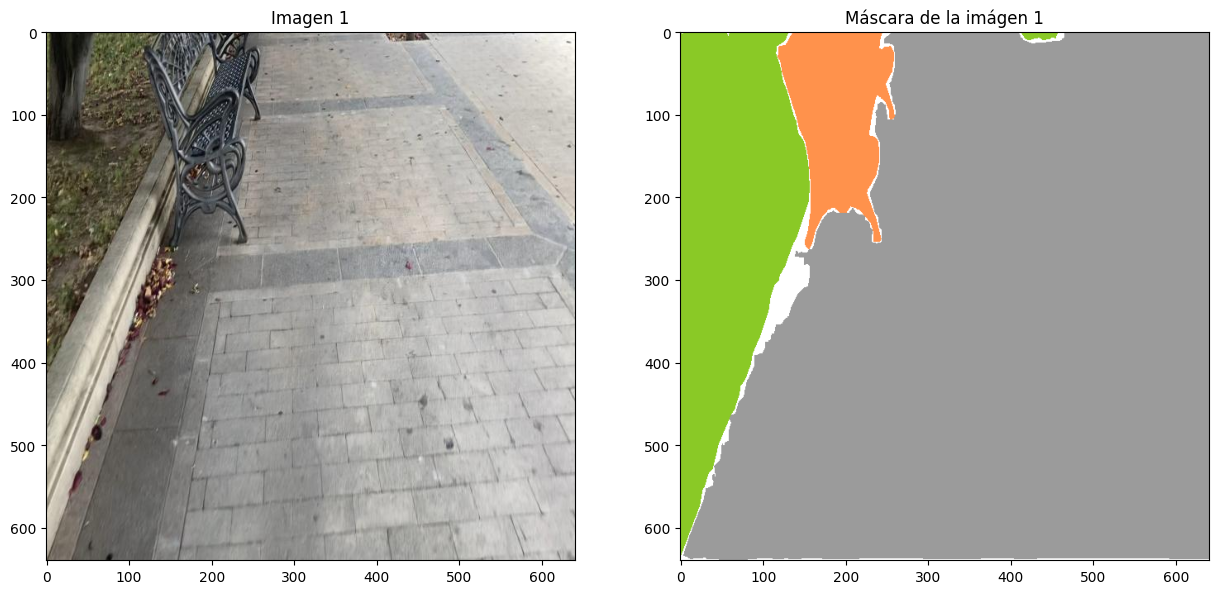

In [73]:
show_images = 2
random_ints = np.random.randint(0, NUM_TRAIN_IMAGES - 1, size=show_images)
for index, num in enumerate(random_ints):
    img_view  = imageio.imread(TRAIN_DIR + train_image_dataset[num])
    mask_view = imageio.imread(TRAIN_DIR + train_mask_dataset[num])
    mask_view_color = label_to_color_image(mask_view).astype(np.uint8)
    print("Dimensión imágen: ", img_view.shape)
    print("Dimensión máscara: ", mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Imagen '+ str(index))
    arr[1].imshow(mask_view_color)
    arr[1].set_title('Máscara de la imágen '+ str(index))

## Preprocesamiento del conjunto de datos


In [12]:
def PreprocessData(image_dataset, mask_dataset, target_shape_img, target_shape_mask, path):
    """
    Preprocesa las imágenes y mascaras presentes en las listas y la ubicación
    pasada como argumento.
    Devuelve dos arrays de cuatro dimensiones que contienen las imágenes y máscaras
    como arrays. Las dimensiones corresponden con lo siguiente:
        Primera dimensión:              número de imágenes/máscaras
        Segunda y tercera dimensión:    ancho y alto deseado
        Cuarta dimensión:               número de canales.
                                            las imágenes 3 canales (RGB)
                                            las máscaras 1 canal (escala de grises)
    """
    # Extraer las dimensiones relevantes
    num_images = len(image_dataset)  # número de imágenes
    i_h,i_w,i_c = target_shape_img   # altura, ancho y canales de una imagen
    m_h,m_w,m_c = target_shape_mask  # altura, ancho y canales de una máscara

    # Definir X e Y como el número de imágenes junto con la dimensión de una imagen
    X = np.zeros((num_images,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((num_images,m_h,m_w,m_c), dtype=np.int32)

    # Redimensionar imágenes y máscaras
    for i in range(num_images):
        # convertir la imagen en un array con la forma deseada
        image_name = image_dataset[i]
        image_path = os.path.join(path, image_name)
        image = Image.open(image_path).convert('RGB')
        image = image.resize((i_h,i_w))
        image = np.reshape(image,(i_h,i_w,i_c))
        image = image/255.
        X[i] = image

        # convertir la máscara en un array con la forma deseada
        mask_name = mask_dataset[i]
        mask_path = os.path.join(path, mask_name)
        mask = Image.open(mask_path)
        mask = mask.resize((m_h, m_w),Image.NEAREST) #Con flag Image.NEAREST para que no se cree una nueva clase por la interpolación de los píxeles
        mask = np.reshape(mask,(m_h,m_w,m_c))

        y[i] = mask

    return X, y

In [13]:
X_train, y_train = PreprocessData(train_image_dataset, train_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, TRAIN_DIR)
X_valid, y_valid = PreprocessData(valid_image_dataset, valid_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, VALID_DIR)
X_test, y_test = PreprocessData(test_image_dataset, test_mask_dataset, TARGET_SHAPE_IMG, TARGET_SHAPE_MASK, TEST_DIR)

print("Dimensión conjunto de imágenes de entrenamiento: ", X_train.shape)
print("Dimensión conjunto de máscaras de entrenamiento: ", y_train.shape)
print("Dimensión conjunto de imágenes de validación: ", X_valid.shape)
print("Dimensión conjunto de máscaras de validación: ", y_valid.shape)
print("Dimensión conjunto de imágenes de prueba: ", X_test.shape)
print("Dimensión conjunto de máscaras de prueba: ", y_test.shape)

y_train_one_hot = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, NUM_CLASSES)
train_dataset_one_hot = tf.data.Dataset.from_tensor_slices((X_train*255.0, y_train_one_hot))
train_dataset_one_hot = train_dataset_one_hot.batch(BATCH_SIZE, drop_remainder=True)
valid_dataset_one_hot = tf.data.Dataset.from_tensor_slices((X_valid*255.0, y_valid_one_hot))
valid_dataset_one_hot = valid_dataset_one_hot.batch(BATCH_SIZE, drop_remainder=True)

print("Dataset de entrenamiento para DeepLab: ", train_dataset_one_hot)
print("Dataset de validación para DeepLab: ", valid_dataset_one_hot)

Dimensión conjunto de imágenes de entrenamiento:  (5217, 128, 128, 3)
Dimensión conjunto de máscaras de entrenamiento:  (5217, 128, 128, 1)
Dimensión conjunto de imágenes de validación:  (495, 128, 128, 3)
Dimensión conjunto de máscaras de validación:  (495, 128, 128, 1)
Dimensión conjunto de imágenes de prueba:  (247, 128, 128, 3)
Dimensión conjunto de máscaras de prueba:  (247, 128, 128, 1)
Dataset de entrenamiento para DeepLab:  <_BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 8), dtype=tf.float32, name=None))>
Dataset de validación para DeepLab:  <_BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 8), dtype=tf.float32, name=None))>


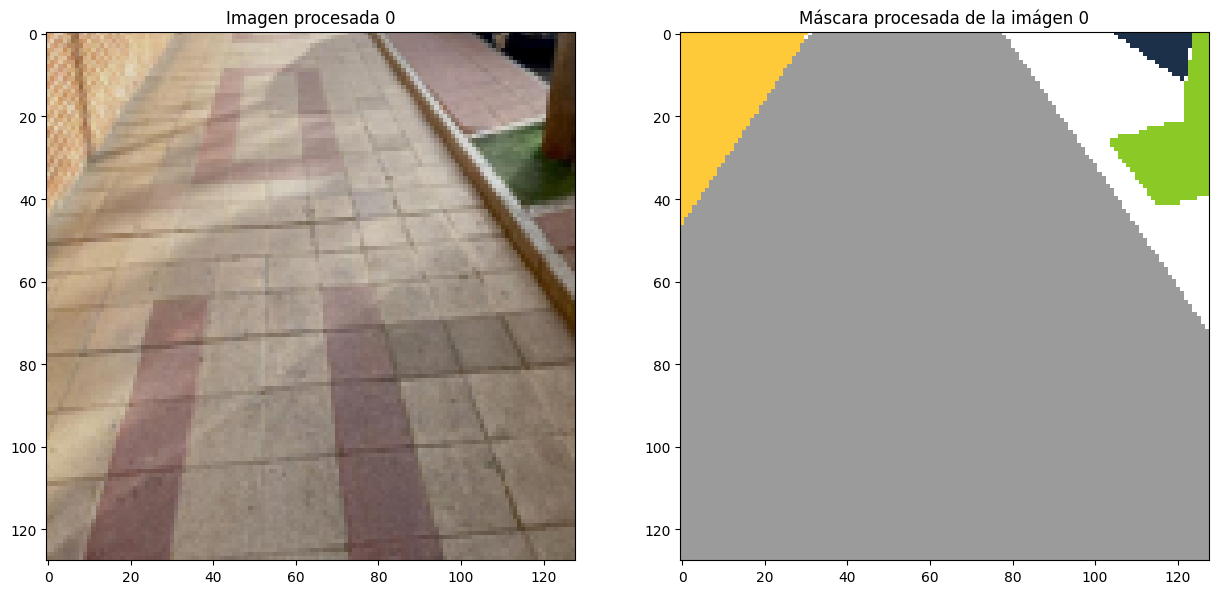

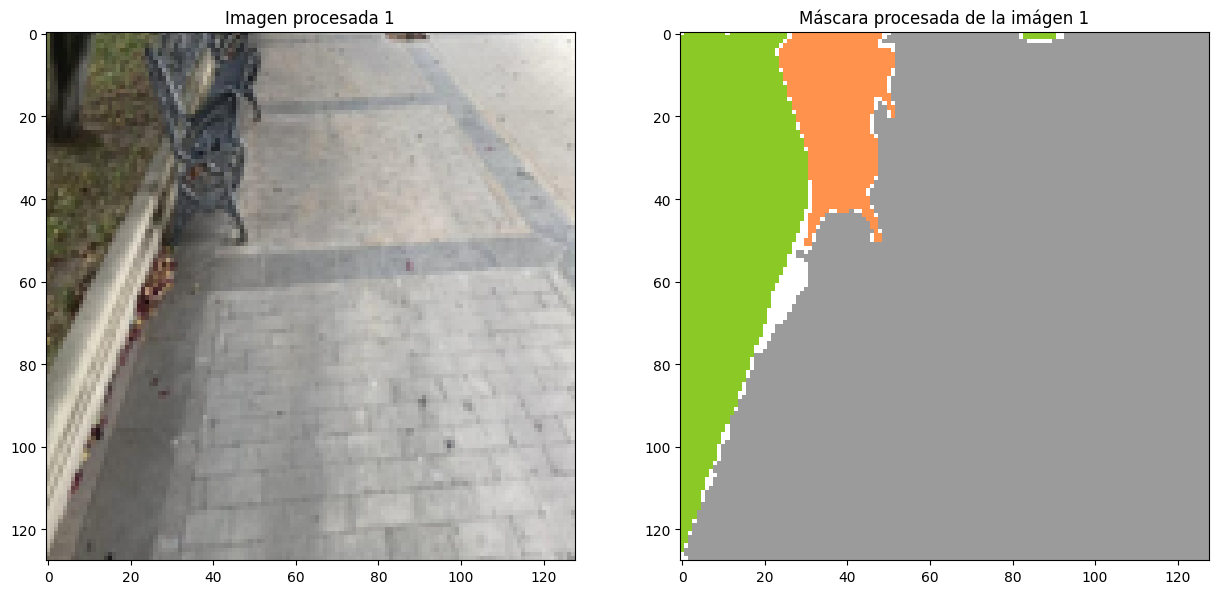

In [74]:
for index, num in enumerate(random_ints):
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(X_train[num])
    arr[0].set_title('Imagen procesada '+ str(index))
    mask_view_color = label_to_color_image(y_train[num,:,:,0]).astype(np.uint8)
    arr[1].imshow(mask_view_color)
    arr[1].set_title('Máscara procesada de la imágen '+ str(index))

## Construcción de las arquitecturas

### Arquitectura SegNet

Modelo obtenido modificando el propuesto por Hashbanger. (2019b, julio 15). Skin Lesion Segmentation using SegNet. Kaggle. https://www.kaggle.com/code/hashbanger/skin-lesion-segmentation-using-segnet#The-Model

In [15]:
def segnet(input_size=(128, 128, 3), n_labels=8, kernel=3, pool_size=(2, 2), output_mode="softmax"):
    # encoder
    inputs = Input(input_size)

    conv_1 = Conv2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Conv2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1 = MaxPooling2D(pool_size)(conv_2)

    conv_3 = Conv2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2 = MaxPooling2D(pool_size)(conv_4)

    conv_5 = Conv2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)


    pool_3 = MaxPooling2D(pool_size)(conv_7)

    conv_8 = Conv2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Conv2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Conv2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)


    pool_4 = MaxPooling2D(pool_size)(conv_10)

    conv_11 = Conv2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)


    pool_5 = MaxPooling2D(pool_size)(conv_13)

    # decoder

    up_1 = UpSampling2D(pool_size)(pool_5)

    conv_14 = Conv2D(512, (kernel, kernel), padding="same")(up_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Conv2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Conv2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)


    up_2 = UpSampling2D(pool_size)(conv_16)

    conv_17 = Conv2D(512, (kernel, kernel), padding="same")(up_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Conv2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Conv2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    up_3 = UpSampling2D(pool_size)(conv_19)

    conv_20 = Conv2D(256, (kernel, kernel), padding="same")(up_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Conv2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Conv2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    up_4 = UpSampling2D(pool_size)(conv_22)

    conv_23 = Conv2D(128, (kernel, kernel), padding="same")(up_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Conv2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    up_5 = UpSampling2D(pool_size)(conv_24)

    conv_25 = Conv2D(64, (kernel, kernel), padding="same")(up_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Conv2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)

    outputs = Activation(output_mode)(conv_26)

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [16]:
model_segnet = segnet(TARGET_SHAPE_IMG, n_labels=NUM_CLASSES ,kernel=3, pool_size=(2,2), output_mode="softmax")

A continuación se muestra la arquitectura detallada

In [17]:
model_segnet.summary()

Model: "SegNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 64)      256       
 chNormalization)                                           

### Arquitectura U-Net


Modelo adaptado de Bhatia, V. (2021). VidushiBhatia/U-Net-Implementation: U Net Implementation from Scratch using TensorFlow (oxford iiit pet dataset. https://github.com/VidushiBhatia/U-Net-Implementation/tree/main

In [18]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [19]:
def UNet(input_size=(128, 128, 3), n_filters=32, n_classes=3):
    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = Model(inputs=inputs, outputs=conv10)

    return model

In [39]:
model_unet = UNet(input_size=TARGET_SHAPE_IMG, n_filters=64, n_classes=NUM_CLASSES)

A continuación se muestra la arquitectura detallada

In [21]:
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_27 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_26[0][0]']           
                                                                                                  
 batch_normalization_26 (Ba  (None, 128, 128, 64)         256       ['conv2d_27[0][0]']           
 tchNormalization)                                                                            

### Arquitectura DeepLabv3+

Modelo adaptado de Rakshit, S. (2024). Multiclass semantic segmentation using DeepLabV3+. https://keras.io/examples/vision/deeplabv3_plus/

In [22]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer='HeNormal',
    )(block_input)
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [23]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = Input(shape=image_size)
    preprocessed = resnet50.preprocess_input(model_input)
    resnet50_model = ResNet50(
        weights="imagenet", include_top=False, input_tensor=preprocessed
    )
    x = resnet50_model.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = UpSampling2D(
        size=(image_size[0] // 4 // x.shape[1], image_size[0] // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50_model.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = UpSampling2D(
        size=(image_size[0] // x.shape[1], image_size[0] // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return Model(inputs=model_input, outputs=model_output)

In [45]:
model_deeplab = DeeplabV3Plus(image_size=TARGET_SHAPE_IMG, num_classes=NUM_CLASSES)

A continuación se muestra la arquitectura detallada

In [25]:
model_deeplab.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 128, 128, 3)          0         ['input_3[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 128, 128, 3)          0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                                                                                            

## Definición de las métricas para utilizar en el entrenamiento

In [26]:
def iou(y_true, y_pred):
  y_pred = K.argmax(y_pred, axis=-1)
  y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

  y_true = K.squeeze(y_true, axis=-1)
  y_true_int = K.cast(y_true, 'int32')
  y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

  intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
  union = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3]) - intersection
  iou = (intersection + K.epsilon()) / (union + K.epsilon())
  return iou

def iou_one_hot(y_true, y_pred):
  y_pred = K.argmax(y_pred, axis=-1)
  y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

  y_true_one_hot = y_true

  intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
  union = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3]) - intersection
  iou = (intersection + K.epsilon()) / (union + K.epsilon())
  return iou

In [27]:
def dice_coef(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')
    y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

    intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
    total_pixels = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3])
    dice_coef = (2 * intersection + K.epsilon()) / (total_pixels + K.epsilon())
    return dice_coef

def dice_coef_one_hot(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true_one_hot = y_true

    intersection = K.sum(y_true_one_hot * y_pred_one_hot, axis=[1,2,3])
    total_pixels = K.sum(y_true_one_hot, axis=[1,2,3]) +  K.sum(y_pred_one_hot, axis=[1,2,3])
    dice_coef = (2 * intersection + K.epsilon()) / (total_pixels + K.epsilon())
    return dice_coef

In [28]:
def precision(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')
    y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    pred_positives = K.sum(y_pred_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (pred_positives + K.epsilon())
    return precision

def precision_one_hot(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true_one_hot = y_true

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    pred_positives = K.sum(y_pred_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (pred_positives + K.epsilon())
    return precision

In [29]:
def recall(y_true, y_pred):

    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')
    y_true_one_hot = K.one_hot(y_true_int, NUM_CLASSES)

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    truth_positives = K.sum(y_true_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (truth_positives + K.epsilon())
    return precision

def recall_one_hot(y_true, y_pred):
    y_pred = K.argmax(y_pred, axis=-1)
    y_pred_one_hot = K.one_hot(y_pred, NUM_CLASSES)

    y_true_one_hot = y_true

    intersection = K.sum(y_pred_one_hot * y_true_one_hot, axis=[1,2,3])
    truth_positives = K.sum(y_true_one_hot, axis=[1,2,3])
    precision = (intersection + K.epsilon()) / (truth_positives + K.epsilon())
    return precision

In [30]:
def accuracy(y_true, y_pred):
    y_pred_int = K.cast(K.argmax(y_pred, axis=-1), 'int32')
    y_true = K.squeeze(y_true, axis=-1)
    y_true_int = K.cast(y_true, 'int32')

    correct_predictions = K.sum(K.cast(K.equal(y_true_int, y_pred_int), dtype='float32'), axis=[1,2])
    total_pixels = K.constant(16384.0, dtype='float32')
    accuracy = (correct_predictions + K.epsilon()) / (total_pixels + K.epsilon())
    return accuracy

def accuracy_one_hot(y_true, y_pred):
    y_pred_int = K.cast(K.argmax(y_pred, axis=-1), 'int32')

    y_true_int = K.cast(K.argmax(y_true, axis=-1), 'int32')

    correct_predictions = K.sum(K.cast(K.equal(y_true_int, y_pred_int), dtype='float32'), axis=[1,2])
    total_pixels = K.constant(16384.0, dtype='float32')
    accuracy = (correct_predictions + K.epsilon()) / (total_pixels + K.epsilon())
    return accuracy

## Entrenamiento

### Arquitectura SegNet


In [31]:
model_segnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[iou, accuracy, dice_coef, recall, precision])

results_segnet = model_segnet.fit(X_train, y_train, batch_size=32, epochs=12, validation_data=(X_valid, y_valid))

Epoch 1/12
164/164 [==============================] - 89s 377ms/step - loss: 1.4722 - iou: 0.5264 - accuracy: 0.6506 - dice_coef: 0.6506 - recall: 0.6506 - precision: 0.6506 - val_loss: 1.6954 - val_iou: 0.4550 - val_accuracy: 0.5673 - val_dice_coef: 0.5673 - val_recall: 0.5673 - val_precision: 0.5673
Epoch 2/12
164/164 [==============================] - 60s 368ms/step - loss: 1.1459 - iou: 0.7009 - accuracy: 0.8032 - dice_coef: 0.8032 - recall: 0.8032 - precision: 0.8032 - val_loss: 1.7193 - val_iou: 0.4309 - val_accuracy: 0.5510 - val_dice_coef: 0.5510 - val_recall: 0.5510 - val_precision: 0.5510
Epoch 3/12
164/164 [==============================] - 60s 364ms/step - loss: 1.0176 - iou: 0.7617 - accuracy: 0.8503 - dice_coef: 0.8503 - recall: 0.8503 - precision: 0.8503 - val_loss: 1.2859 - val_iou: 0.6403 - val_accuracy: 0.7446 - val_dice_coef: 0.7446 - val_recall: 0.7446 - val_precision: 0.7446
Epoch 4/12
164/164 [==============================] - 60s 364ms/step - loss: 0.9743 - iou: 

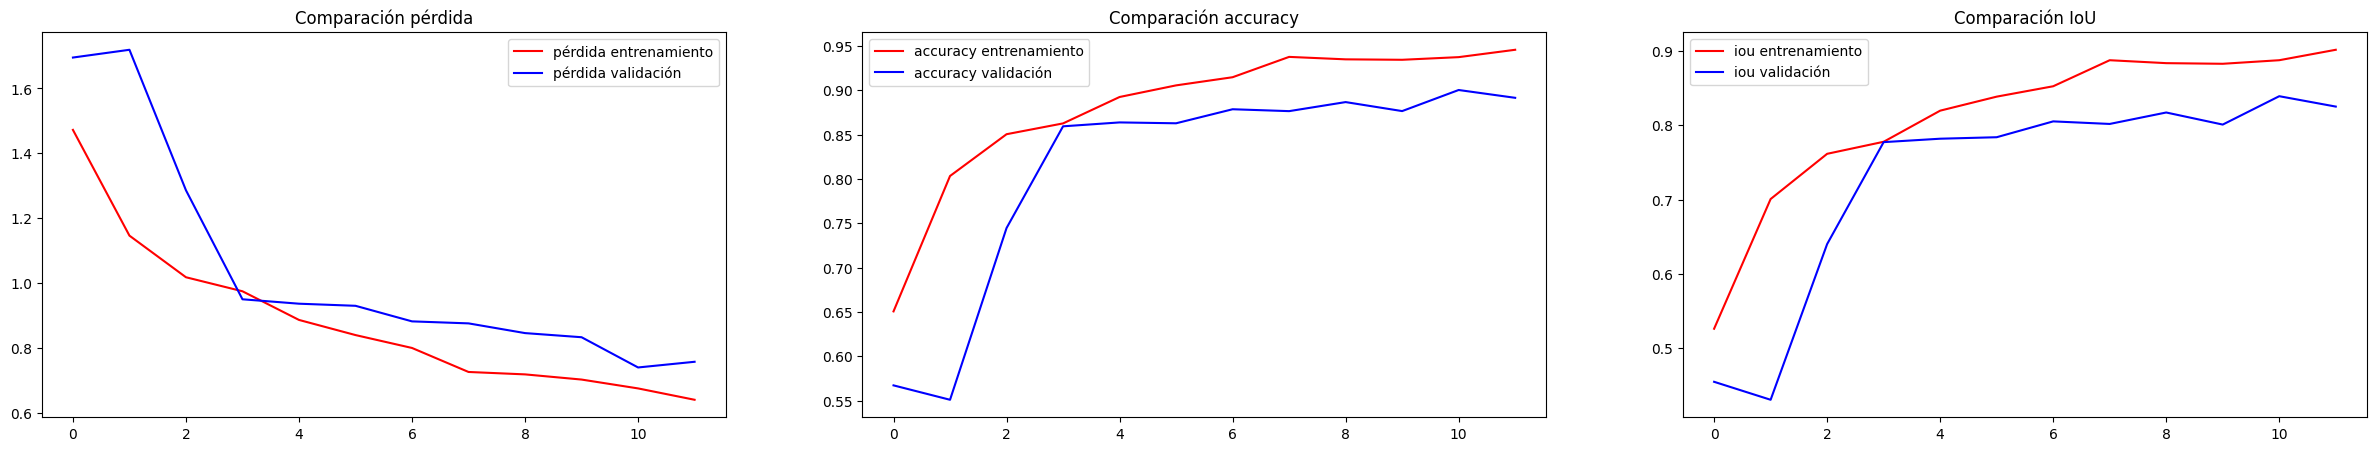

In [34]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_segnet.history["loss"], color='r', label = 'pérdida entrenamiento')
axis[0].plot(results_segnet.history["val_loss"], color='b', label = 'pérdida validación')
axis[0].set_title('Comparación pérdida')
axis[0].legend()
axis[1].plot(results_segnet.history["accuracy"], color='r', label = 'accuracy entrenamiento')
axis[1].plot(results_segnet.history["val_accuracy"], color='b', label = 'accuracy validación')
axis[1].set_title('Comparación accuracy')
axis[1].legend()
axis[2].plot(results_segnet.history["iou"], color='r', label = 'iou entrenamiento')
axis[2].plot(results_segnet.history["val_iou"], color='b', label = 'iou validación')
axis[2].set_title('Comparación IoU')
axis[2].legend()

### Arquitectura U-Net

In [40]:
model_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[iou, accuracy, dice_coef, recall, precision])

results_unet = model_unet.fit(X_train, y_train, batch_size=32, epochs=12, validation_data=(X_valid, y_valid))

Epoch 1/12
164/164 [==============================] - 103s 590ms/step - loss: 1.3393 - iou: 0.4781 - accuracy: 0.5871 - dice_coef: 0.5871 - recall: 0.5871 - precision: 0.5871 - val_loss: 1.0148 - val_iou: 0.5353 - val_accuracy: 0.6568 - val_dice_coef: 0.6568 - val_recall: 0.6568 - val_precision: 0.6568
Epoch 2/12
164/164 [==============================] - 97s 590ms/step - loss: 0.8800 - iou: 0.5979 - accuracy: 0.7193 - dice_coef: 0.7193 - recall: 0.7193 - precision: 0.7193 - val_loss: 0.7454 - val_iou: 0.6399 - val_accuracy: 0.7592 - val_dice_coef: 0.7592 - val_recall: 0.7592 - val_precision: 0.7592
Epoch 3/12
164/164 [==============================] - 96s 588ms/step - loss: 0.6435 - iou: 0.6950 - accuracy: 0.7999 - dice_coef: 0.7999 - recall: 0.7999 - precision: 0.7999 - val_loss: 0.5422 - val_iou: 0.7447 - val_accuracy: 0.8352 - val_dice_coef: 0.8352 - val_recall: 0.8352 - val_precision: 0.8352
Epoch 4/12
164/164 [==============================] - 97s 590ms/step - loss: 0.5152 - iou:

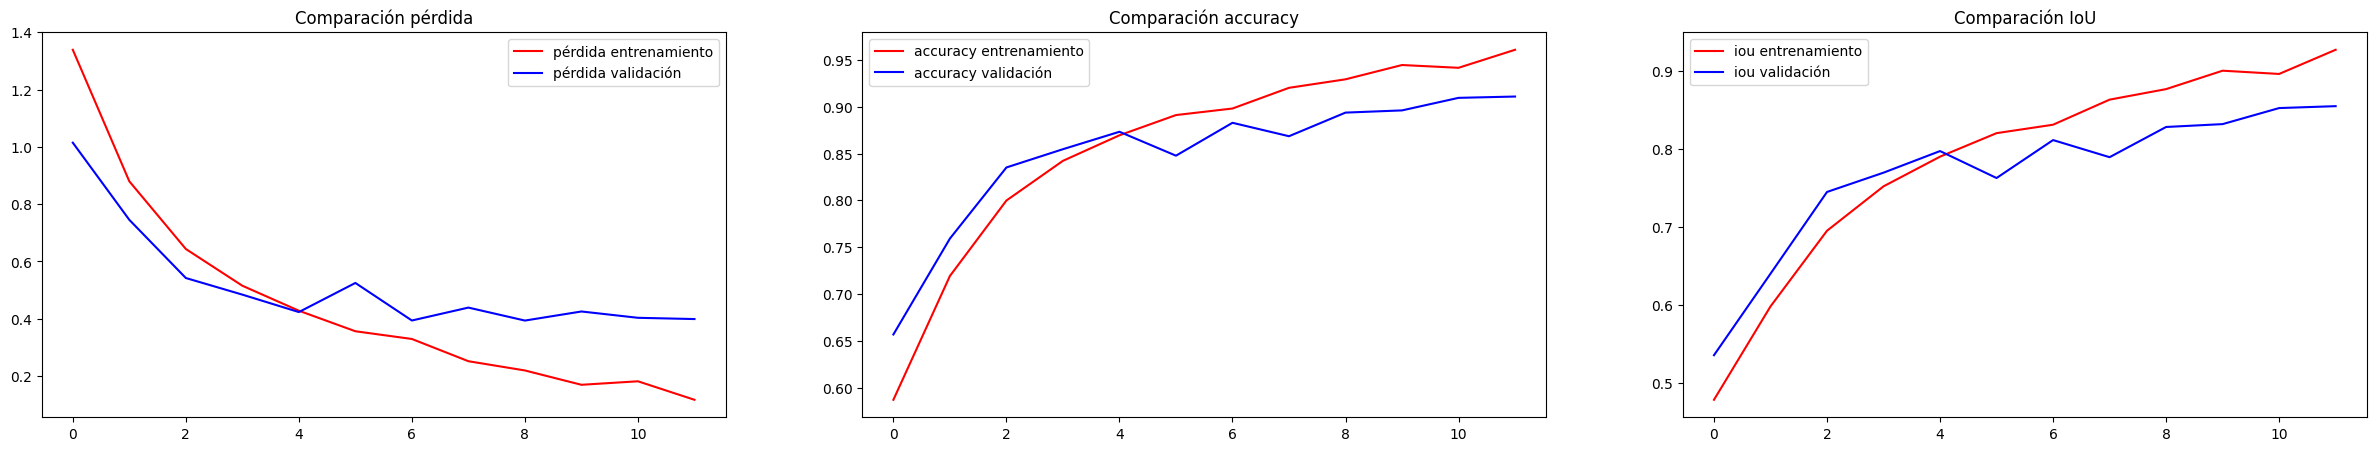

In [41]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_unet.history["loss"], color='r', label = 'pérdida entrenamiento')
axis[0].plot(results_unet.history["val_loss"], color='b', label = 'pérdida validación')
axis[0].set_title('Comparación pérdida')
axis[0].legend()
axis[1].plot(results_unet.history["accuracy"], color='r', label = 'accuracy entrenamiento')
axis[1].plot(results_unet.history["val_accuracy"], color='b', label = 'accuracy validación')
axis[1].set_title('Comparación accuracy')
axis[1].legend()
axis[2].plot(results_unet.history["iou"], color='r', label = 'iou entrenamiento')
axis[2].plot(results_unet.history["val_iou"], color='b', label = 'iou validación')
axis[2].set_title('Comparación IoU')
axis[2].legend()

### Arquitectura DeepLabv3+

In [46]:
model_deeplab.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True),
              metrics=[accuracy_one_hot, iou_one_hot, dice_coef_one_hot, precision_one_hot, recall_one_hot])

results_deeplab = model_deeplab.fit(train_dataset_one_hot, validation_data=valid_dataset_one_hot, epochs=12)

Epoch 1/12
163/163 [==============================] - 64s 247ms/step - loss: 0.1434 - accuracy_one_hot: 0.7215 - iou_one_hot: 0.6037 - dice_coef_one_hot: 0.7215 - precision_one_hot: 0.7215 - recall_one_hot: 0.7215 - val_loss: 0.0884 - val_accuracy_one_hot: 0.8406 - val_iou_one_hot: 0.7480 - val_dice_coef_one_hot: 0.8406 - val_precision_one_hot: 0.8406 - val_recall_one_hot: 0.8406
Epoch 2/12
163/163 [==============================] - 39s 237ms/step - loss: 0.0759 - accuracy_one_hot: 0.8374 - iou_one_hot: 0.7447 - dice_coef_one_hot: 0.8374 - precision_one_hot: 0.8374 - recall_one_hot: 0.8374 - val_loss: 0.0655 - val_accuracy_one_hot: 0.8700 - val_iou_one_hot: 0.7899 - val_dice_coef_one_hot: 0.8700 - val_precision_one_hot: 0.8700 - val_recall_one_hot: 0.8700
Epoch 3/12
163/163 [==============================] - 39s 239ms/step - loss: 0.0457 - accuracy_one_hot: 0.8981 - iou_one_hot: 0.8286 - dice_coef_one_hot: 0.8981 - precision_one_hot: 0.8981 - recall_one_hot: 0.8981 - val_loss: 0.0549 -

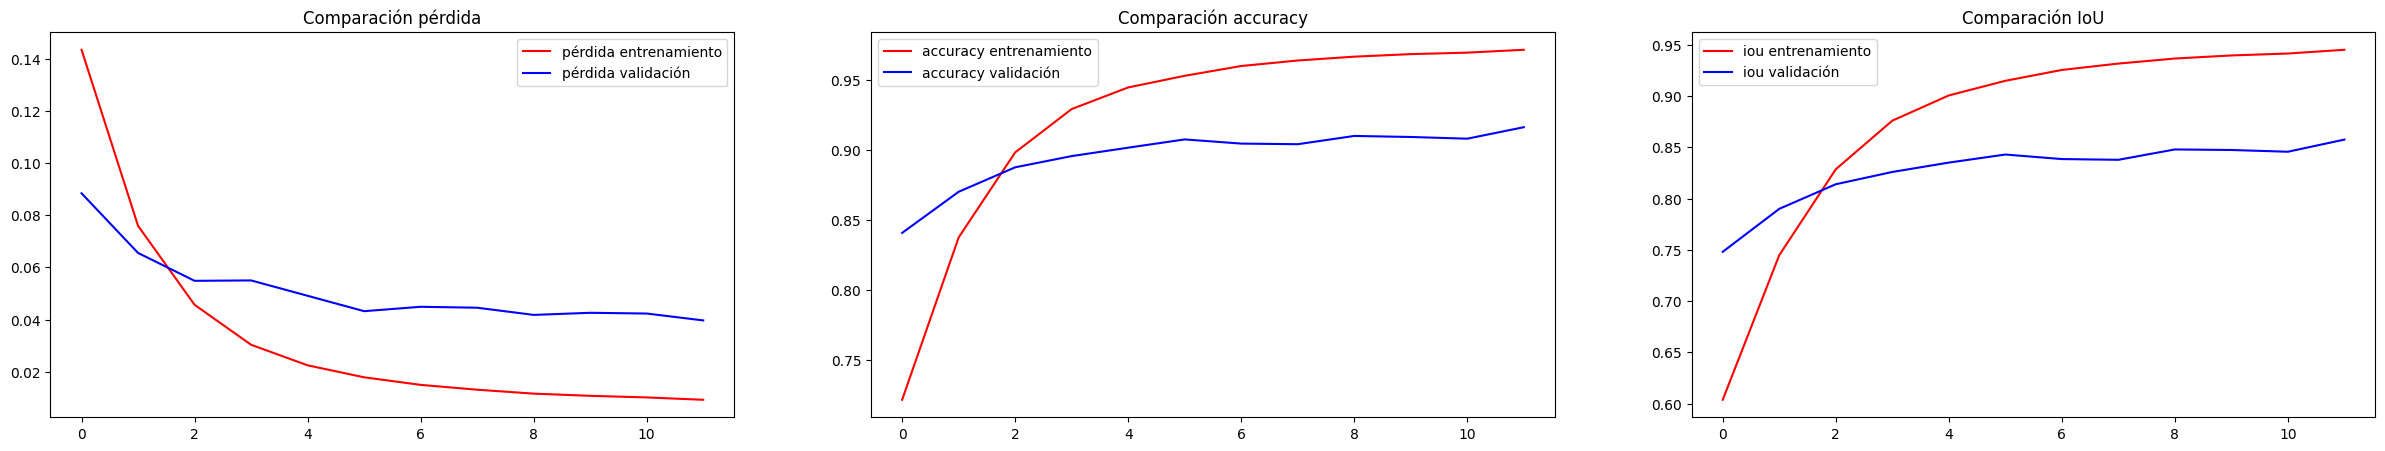

In [47]:
fig, axis = plt.subplots(1, 3, figsize=(30, 5))
axis[0].plot(results_deeplab.history["loss"], color='r', label = 'pérdida entrenamiento')
axis[0].plot(results_deeplab.history["val_loss"], color='b', label = 'pérdida validación')
axis[0].set_title('Comparación pérdida')
axis[0].legend()
axis[1].plot(results_deeplab.history["accuracy_one_hot"], color='r', label = 'accuracy entrenamiento')
axis[1].plot(results_deeplab.history["val_accuracy_one_hot"], color='b', label = 'accuracy validación')
axis[1].set_title('Comparación accuracy')
axis[1].legend()
axis[2].plot(results_deeplab.history["iou_one_hot"], color='r', label = 'iou entrenamiento')
axis[2].plot(results_deeplab.history["val_iou_one_hot"], color='b', label = 'iou validación')
axis[2].set_title('Comparación IoU')
axis[2].legend()

### Resultados del entrenamiento de los distintos modelos superpuestos

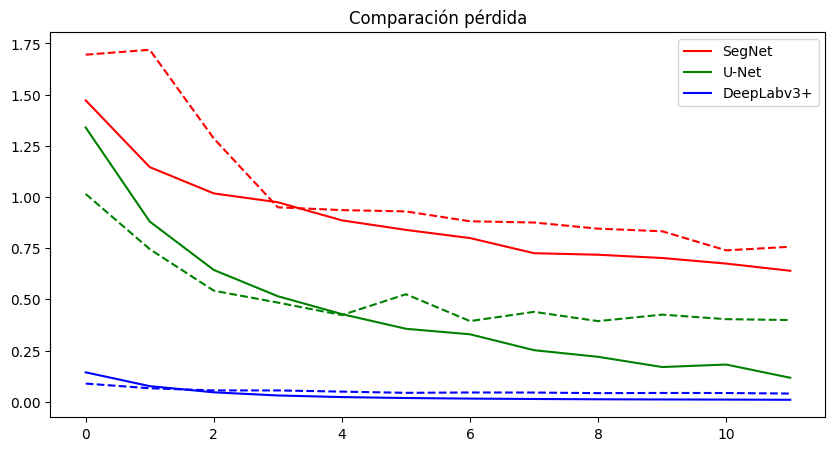

In [48]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.plot(results_segnet.history["loss"], color='r', linestyle='-', label='SegNet')
axis.plot(results_segnet.history["val_loss"], color='r', linestyle='--')
axis.plot(results_unet.history["loss"], color='g', linestyle='-', label='U-Net')
axis.plot(results_unet.history["val_loss"], color='g', linestyle='--')
axis.plot(results_deeplab.history["loss"], color='b', linestyle='-', label='DeepLabv3+')
axis.plot(results_deeplab.history["val_loss"], color='b', linestyle='--')
axis.set_title('Comparación pérdida')
axis.legend()

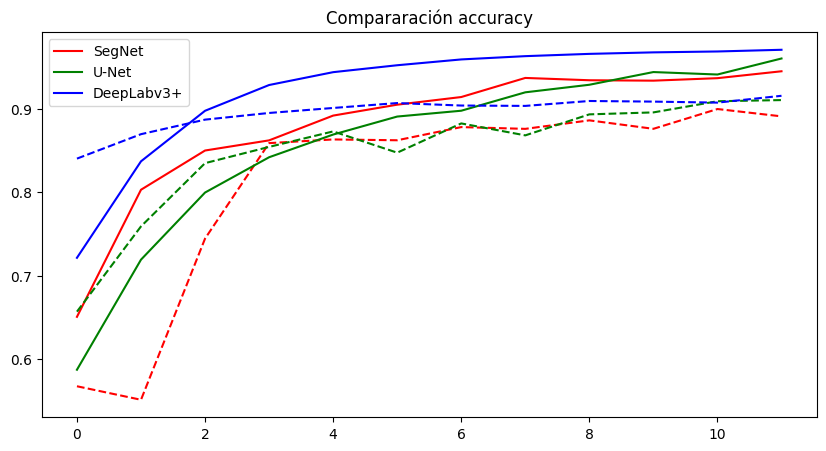

In [49]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.plot(results_segnet.history["accuracy"], color='r', linestyle='-', label='SegNet')
axis.plot(results_segnet.history["val_accuracy"], color='r', linestyle='--')
axis.plot(results_unet.history["accuracy"], color='g', linestyle='-', label='U-Net')
axis.plot(results_unet.history["val_accuracy"], color='g', linestyle='--')
axis.plot(results_deeplab.history["accuracy_one_hot"], color='b', linestyle='-', label='DeepLabv3+')
axis.plot(results_deeplab.history["val_accuracy_one_hot"], color='b', linestyle='--')
axis.set_title('Compararación accuracy')
axis.legend()

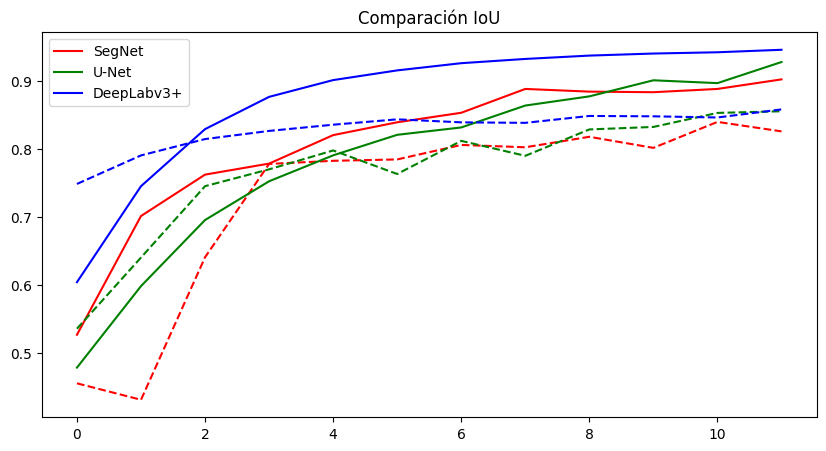

In [50]:
fig, axis = plt.subplots(figsize=(10, 5))
axis.plot(results_segnet.history["iou"], color='r', linestyle='-', label='SegNet')
axis.plot(results_segnet.history["val_iou"], color='r', linestyle='--')
axis.plot(results_unet.history["iou"], color='g', linestyle='-', label='U-Net')
axis.plot(results_unet.history["val_iou"], color='g', linestyle='--')
axis.plot(results_deeplab.history["iou_one_hot"], color='b', linestyle='-', label='DeepLabv3+')
axis.plot(results_deeplab.history["val_iou_one_hot"], color='b', linestyle='--')
axis.set_title('Comparación IoU')
axis.legend()

## Evaluación del modelo

In [51]:
def print_classes_score(score):
    print("\tFondo:\t\t\t{:.2f}".format(score[0] * 100))
    print("\tAcera:\t\t\t{:.2f}".format(score[1] * 100))
    print("\tBaldosas podotáctiles:\t{:.2f}".format(score[2] * 100))
    print("\tBanco:\t\t\t{:.2f}".format(score[3] * 100))
    print("\tCarretera:\t\t{:.2f}".format(score[4] * 100))
    print("\tPared:\t\t\t{:.2f}".format(score[5] * 100))
    print("\tPaso de cebra:\t\t{:.2f}".format(score[6] * 100))
    print("\tVegetación:\t\t{:.2f}".format(score[7] * 100))
    return

### Arquitectura SegNet

In [75]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_segnet.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 23ms/step


In [76]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

(7.5, -0.5)

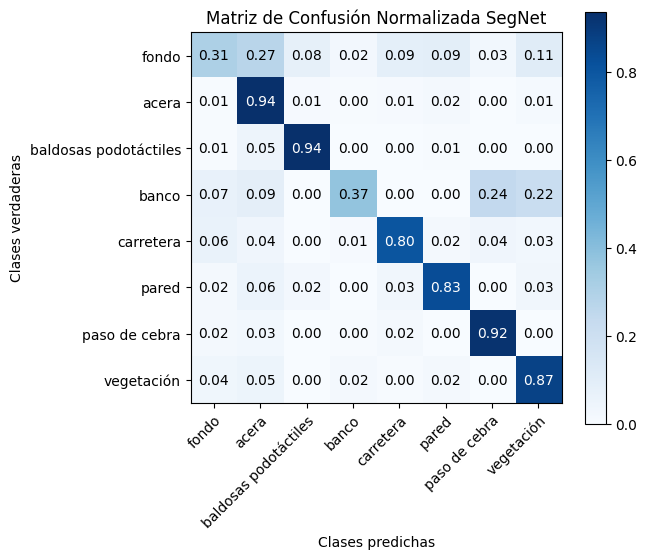

In [87]:
# Evaluating Semantic Segmentation Models — Deep learning with TensorFlow. (s. f.). https://developmentseed.org/tensorflow-eo-training/docs/Lesson4_evaluation.html

%matplotlib inline
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax, shrink=0.75)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=CLASSES_NAMES, yticklabels=CLASSES_NAMES,
       title='Matriz de Confusión Normalizada SegNet',
       ylabel='Clases verdaderas',
       xlabel='Clases predichas')


plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# recorrer los datos y escribir los valores de la matriz
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(NUM_CLASSES-0.5, -0.5)

In [88]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 88.95
global accuracy: 88.95
global precision: 88.95
global recall: 88.95
global iou: 80.09
----------------------------------
weighted dice_coef: 88.93
weighted precision: 89.15
weighted recall: 88.95
weighted iou: 81.80
----------------------------------
Dice_coef per class: 
	Fondo:			34.42
	Acera:			94.64
	Baldosas podotáctiles:	88.09
	Banco:			37.69
	Carretera:		81.03
	Pared:			82.34
	Paso de cebra:		93.51
	Vegetación:		70.79
Precision per class: 
	Fondo:			39.12
	Acera:			95.60
	Baldosas podotáctiles:	83.09
	Banco:			38.04
	Carretera:		81.77
	Pared:			81.29
	Paso de cebra:		94.61
	Vegetación:		59.69
Recall per class: 
	Fondo:			30.73
	Acera:			93.70
	Baldosas podotáctiles:	93.73
	Banco:			37.35
	Carretera:		80.30
	Pared:			83.42
	Paso de cebra:		92.44
	Vegetación:		86.94
IoU per class: 
	Fondo:			20.79
	Acera:			89.83
	Baldosas podotáctiles:	78.71
	Banco:			23.22
	Carretera:		68.11
	Pared:			69.99
	Paso de cebra:		87.81
	Vegeta

### Arquitectura U-Net

In [99]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]
    image = image[np.newaxis, ...]
    pred_y = model_unet.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 18ms/step


In [100]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

(7.5, -0.5)

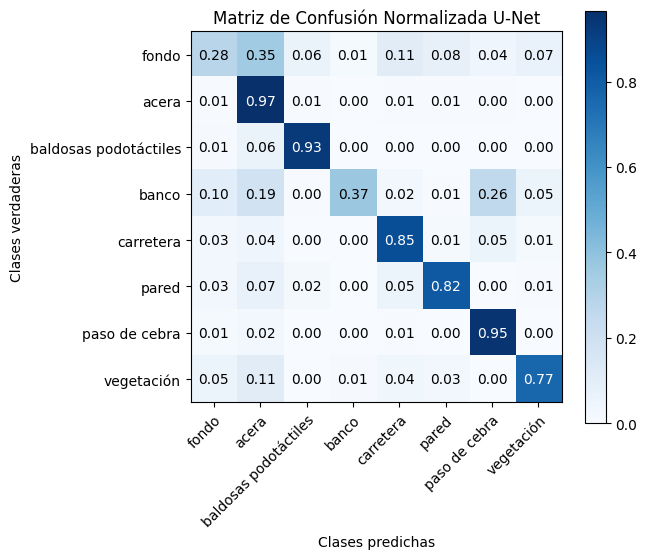

In [101]:
%matplotlib inline
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax, shrink=0.75)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=CLASSES_NAMES, yticklabels=CLASSES_NAMES,
       title='Matriz de Confusión Normalizada U-Net',
       ylabel='Clases verdaderas',
       xlabel='Clases predichas')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(NUM_CLASSES-0.5, -0.5)

In [102]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 90.79
global accuracy: 90.79
global precision: 90.79
global recall: 90.79
global iou: 83.13
----------------------------------
weighted dice_coef: 90.34
weighted precision: 90.13
weighted recall: 90.79
weighted iou: 84.00
----------------------------------
Dice_coef per class: 
	Fondo:			33.55
	Acera:			95.56
	Baldosas podotáctiles:	89.13
	Banco:			47.92
	Carretera:		84.08
	Pared:			85.11
	Paso de cebra:		93.92
	Vegetación:		79.06
Precision per class: 
	Fondo:			41.74
	Acera:			94.50
	Baldosas podotáctiles:	85.78
	Banco:			68.01
	Carretera:		82.81
	Pared:			89.05
	Paso de cebra:		92.85
	Vegetación:		81.66
Recall per class: 
	Fondo:			28.05
	Acera:			96.64
	Baldosas podotáctiles:	92.75
	Banco:			36.99
	Carretera:		85.38
	Pared:			81.51
	Paso de cebra:		95.01
	Vegetación:		76.63
IoU per class: 
	Fondo:			20.16
	Acera:			91.50
	Baldosas podotáctiles:	80.39
	Banco:			31.51
	Carretera:		72.53
	Pared:			74.09
	Paso de cebra:		88.53
	Vegeta

### Arquitectura DeepLabv3+

In [103]:
m = len(X_test)
m_h,m_w,m_c = [128, 128, 1]
pred_test = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

for i in range(len(X_test)):
    image=X_test[i]*255.0
    image = image[np.newaxis, ...]
    pred_y = model_deeplab.predict(image)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_test[i]=pred_mask

1/1 [==============================] - 0s 20ms/step


In [104]:
#Por si acaso alguna imagen no tiene las dimensiones correctas para no tenerla en cuenta
label_arr_lst=y_test
pred_arr_lst=pred_test

pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:

        print(f"La máscara {i} tiene una dimensión incorrecta, se salta.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)

    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

(7.5, -0.5)

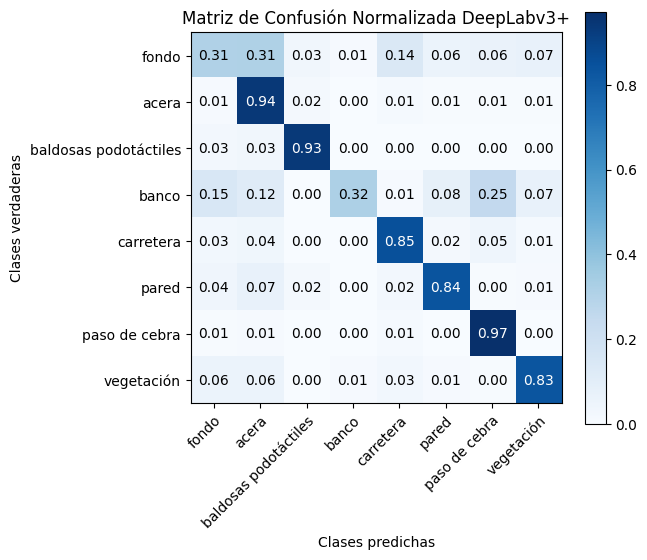

In [105]:
%matplotlib inline
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(NUM_CLASSES)))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax, shrink=0.75)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=CLASSES_NAMES, yticklabels=CLASSES_NAMES,
       title='Matriz de Confusión Normalizada DeepLabv3+',
       ylabel='Clases verdaderas',
       xlabel='Clases predichas')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(NUM_CLASSES-0.5, -0.5)

In [106]:
precision_res = precision_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='micro', zero_division=1.0)
accuracy_res = accuracy_score(flat_truth, flat_preds)

print('----------------------------------')
print("global dice_coef: {:.2f}".format(dice_coef_res * 100))
print("global accuracy: {:.2f}".format(accuracy_res * 100))
print("global precision: {:.2f}".format(precision_res * 100))
print("global recall: {:.2f}".format(recall_res * 100))
print("global iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average='weighted', zero_division=1.0)

print('----------------------------------')
print("weighted dice_coef: {:.2f}".format(dice_coef_res * 100))
print("weighted precision: {:.2f}".format(precision_res * 100))
print("weighted recall: {:.2f}".format(recall_res * 100))
print("weighted iou: {:.2f}".format(iou_res * 100))

precision_res = precision_score(flat_truth, flat_preds, average=None, zero_division=1.0)
recall_res = recall_score(flat_truth, flat_preds, average=None, zero_division=1.0)
iou_res = jaccard_score(flat_truth, flat_preds, average=None, zero_division=1.0)
dice_coef_res = f1_score(flat_truth, flat_preds, average=None, zero_division=1.0)

print('----------------------------------')
print("Dice_coef per class: ")
print_classes_score(dice_coef_res)
print("Precision per class: ")
print_classes_score(precision_res)
print("Recall per class: ")
print_classes_score(recall_res)
print("IoU per class: ")
print_classes_score(iou_res)

----------------------------------
global dice_coef: 90.05
global accuracy: 90.05
global precision: 90.05
global recall: 90.05
global iou: 81.89
----------------------------------
weighted dice_coef: 89.84
weighted precision: 89.90
weighted recall: 90.05
weighted iou: 83.16
----------------------------------
Dice_coef per class: 
	Fondo:			33.47
	Acera:			94.89
	Baldosas podotáctiles:	86.02
	Banco:			43.44
	Carretera:		82.91
	Pared:			86.64
	Paso de cebra:		94.29
	Vegetación:		79.63
Precision per class: 
	Fondo:			36.51
	Acera:			95.75
	Baldosas podotáctiles:	79.65
	Banco:			68.43
	Carretera:		80.71
	Pared:			89.71
	Paso de cebra:		91.54
	Vegetación:		76.37
Recall per class: 
	Fondo:			30.90
	Acera:			94.04
	Baldosas podotáctiles:	93.49
	Banco:			31.82
	Carretera:		85.22
	Pared:			83.78
	Paso de cebra:		97.21
	Vegetación:		83.17
IoU per class: 
	Fondo:			20.10
	Acera:			90.27
	Baldosas podotáctiles:	75.47
	Banco:			27.74
	Carretera:		70.80
	Pared:			76.43
	Paso de cebra:		89.19
	Vegeta

## Visualización de predicciones

In [107]:
def VisualizeResults(index):
    img = X_test[index]
    img = img[np.newaxis, ...]
    pred_y_segnet = model_segnet.predict(img)
    pred_mask_segnet = tf.argmax(pred_y_segnet[0], axis=-1)
    pred_mask_color_segnet = label_to_color_image(pred_mask_segnet).astype(np.uint8)
    pred_y_unet = model_unet.predict(img)
    pred_mask_unet = tf.argmax(pred_y_unet[0], axis=-1)
    pred_mask_color_unet = label_to_color_image(pred_mask_unet).astype(np.uint8)
    img = X_test[index]*255.0
    img = img[np.newaxis, ...]
    pred_y_deeplab = model_deeplab.predict(img)
    pred_mask_deeplab = tf.argmax(pred_y_deeplab[0], axis=-1)
    pred_mask_color_deeplab = label_to_color_image(pred_mask_deeplab).astype(np.uint8)
    truth_mask_color = label_to_color_image(y_test[index,:,:,0]).astype(np.uint8)
    fig, arr = plt.subplots(1, 5, figsize=(15, 25))
    arr[0].imshow(X_test[index])
    arr[0].set_title('Imagen preprocesada')
    arr[1].imshow(truth_mask_color)
    arr[1].set_title('Máscara real')
    arr[2].imshow(pred_mask_color_segnet)
    arr[2].set_title('Máscara predicha SegNet')
    arr[3].imshow(pred_mask_color_unet)
    arr[3].set_title('Máscara predicha U-Net')
    arr[4].imshow(pred_mask_color_deeplab)
    arr[4].set_title('Máscara predicha DeepLab')

1/1 [==============================] - 0s 21ms/step


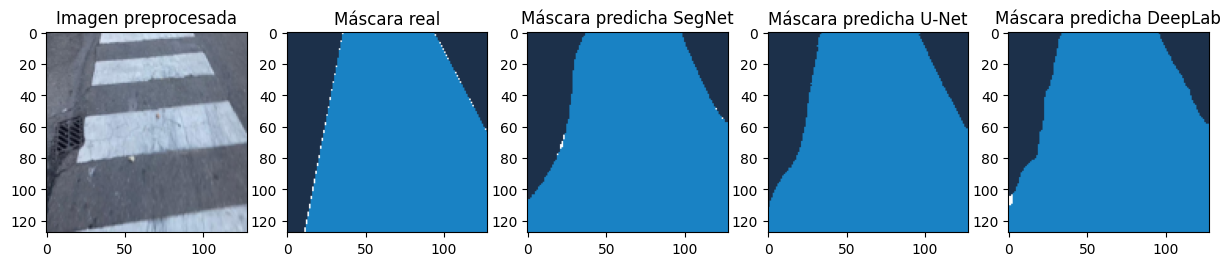

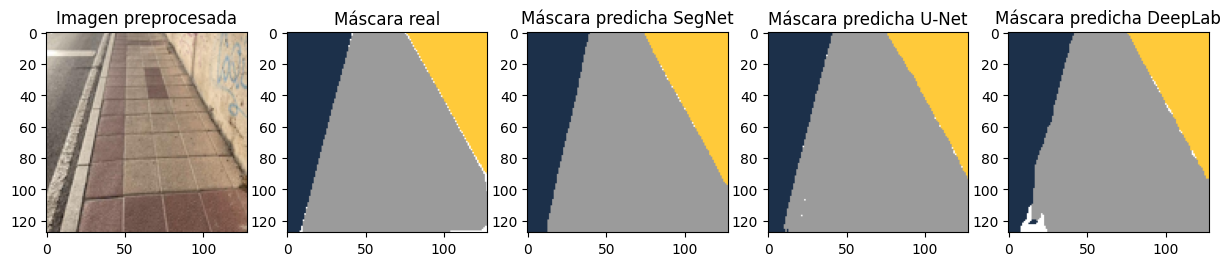

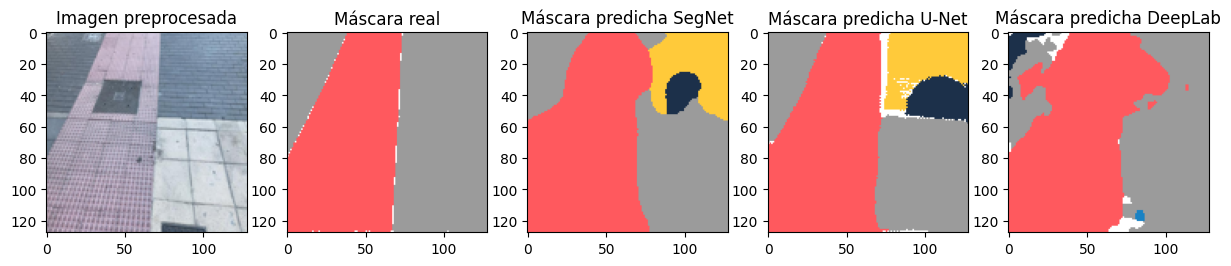

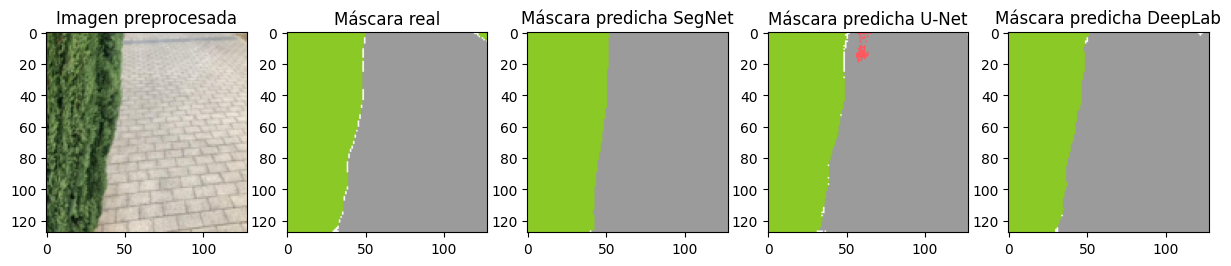

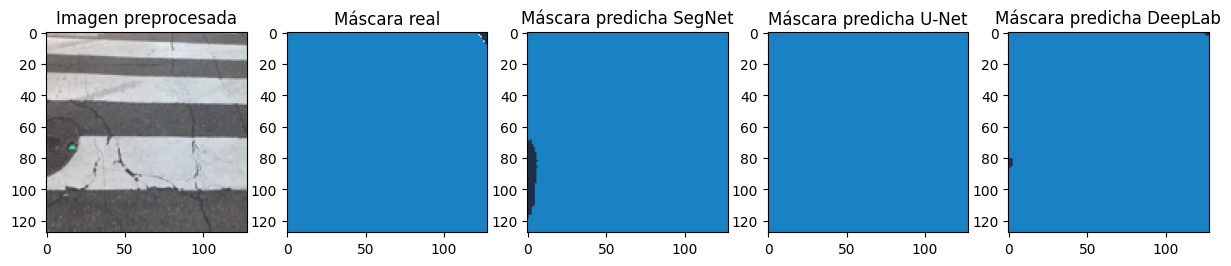

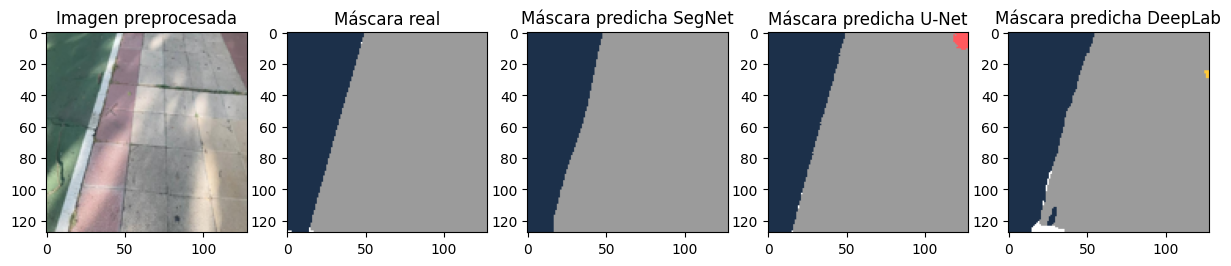

In [108]:
show_images = 6
random_ints = np.random.randint(0, NUM_TEST_IMAGES - 1, size=show_images)
for num in random_ints:
    VisualizeResults(num)

## Descarga del modelo entrenado

In [66]:
!pip install pyyaml h5py
model_unet.save('/content/modelo_unet.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
